In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

En este script procesare los datos de la misma forma que el script V3 con la diferencia de
alguna transformacion externa de caracteristica. 
La prediccion la realizare con la tecniva voting classifier.

In [2]:
df_train = pd.read_csv('train.csv', index_col='id')
df_train

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             20758

In [4]:
# Castear variables float a enteras (teniendo en cuenta las fracciones de algunas caracteristicas)
def feature_float_int (df):
    df_copy = df.copy()
    columns_to_transform = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

    for i in columns_to_transform:
        if i == 'Age':                         
            df_copy[i]=df_copy[i].astype(int)
        else: df_copy[i]=round(df_copy[i]).astype(int)
        
    if any(df_copy[column].dtype !='int32' for column in columns_to_transform):
        print('Error: No se casteo correctamente alguna caracteristica')
        return df_copy
    
    print('Casteo realizado con exito')
    return df_copy

In [5]:
df_train = feature_float_int(df_train)
df_train.head()

Casteo realizado con exito


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24,1.699998,81.669950,yes,yes,2,3,Sometimes,no,3,no,0,1,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18,1.560000,57.000000,yes,yes,2,3,Frequently,no,2,no,1,1,no,Automobile,Normal_Weight
2,Female,18,1.711460,50.165754,yes,yes,2,1,Sometimes,no,2,no,1,2,no,Public_Transportation,Insufficient_Weight
3,Female,20,1.710730,131.274851,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31,1.914186,93.798055,yes,yes,3,2,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
# Eliminar valores atipicos de Age y Height

def delete_outliers (df):
    df_copy = df.copy()
    out=[]

    print('Tamaño del df antes de remover outliers:',df_copy.shape)
    columns_outliers = ['Age', 'Height']

    for i in columns_outliers:
        q1 = df_copy[i].quantile(0.25)
        q3 = df_copy[i].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
    
        outliers = df_copy[(df_copy[i] < Lower_tail) | (df_copy[i] > Upper_tail)]
        out.extend(outliers.index)

    out = list(set(out))
    df_copy = df_copy.drop(out)
    print("Outliers removidos. Tamaño del nuevo df:", df_copy.shape)
    return df_copy

In [7]:
df_train= delete_outliers (df_train)

Tamaño del df antes de remover outliers: (20758, 17)
Outliers removidos. Tamaño del nuevo df: (19725, 17)


In [8]:
# Funcion que redondea a dos decimales altura y peso
def round_weight_height(df):
    df_copy = df.copy()
    columns = ['Height', 'Weight']

    for i in columns:
        df_copy[i] = round(df_copy[i],2)
    print('redondeo de peso y altura realizado')
    return df_copy

In [9]:
df_train = round_weight_height(df_train)

redondeo de peso y altura realizado


In [10]:
# Funcion que calcula el IMC y la añade como variable nueva
def imc_calculator(df):
    df_copy = df.copy()
    
    df_copy['IMC'] = round(df_copy['Weight']/(df_copy['Height']**2),1)
    print('Calculo de IMC insertado en columna nueva y realizado correctamente')
    return df_copy

In [11]:
df_train=imc_calculator(df_train)

Calculo de IMC insertado en columna nueva y realizado correctamente


In [12]:
# Movemos la variable objetivo al final de df
column_pop = df_train.pop('NObeyesdad')
df_train.insert(17, 'NObeyesdad', column_pop)

In [50]:
# Separamos en X e y
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, 17]

In [16]:
# Funcion para eliminar columnas cuyas distribucion es < 90%
def del_column(X):
    X_copy = X.copy()

    X_copy.drop(['SMOKE', 'SCC'], inplace=True, axis=1)
    print('eliminacion de variables no entrenadas...')
    return X_copy

In [51]:
X = del_column(X)

eliminacion de variables no entrenadas...


In [52]:
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,IMC
id,,,,,,,,,,,,,,,
0,Male,24,1.70,81.67,yes,yes,2,3,Sometimes,3,0,1,Sometimes,Public_Transportation,28.3
1,Female,18,1.56,57.00,yes,yes,2,3,Frequently,2,1,1,no,Automobile,23.4
2,Female,18,1.71,50.17,yes,yes,2,1,Sometimes,2,1,2,no,Public_Transportation,17.2
3,Female,20,1.71,131.27,yes,yes,3,3,Sometimes,2,1,1,Sometimes,Public_Transportation,44.9
4,Male,31,1.91,93.80,yes,yes,3,2,Sometimes,2,2,1,Sometimes,Public_Transportation,25.7


In [21]:
# Codificar valores categoricos
def dummies_variable (X):
    X_copy = X.copy()
    categorical_var = X_copy.select_dtypes(include='object')

    # Creamos instancia de encoder
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(categorical_var)
    # Codificamos
    categorical_encoded = encoder.transform(categorical_var)

    # Convertimos a df
    X_copy = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_var.columns))
    print('Codificacion a dummies correctamente...')
    return X_copy

In [53]:
X_categorical = dummies_variable (X)

Codificacion a dummies correctamente...


In [22]:
# Normalizar los datos nuemericos
def normalizer_numerical (X):
    X_copy = X.copy()
    numerical_val = X_copy.select_dtypes(include='number')
    columns_name = numerical_val.columns
    # escalado y transformacion
    scaler = StandardScaler()
    nuemrical_scaled = scaler.fit_transform(numerical_val)

    # Convertimos a df
    numerical_df = pd.DataFrame(nuemrical_scaled, columns=columns_name)
    print('Normalizacion de variables numericas correcta')
    return numerical_df

In [54]:
X_numerical = normalizer_numerical (X)

Normalizacion de variables numericas correcta


In [24]:
# Funcion para concatenar categoricas y numericas
def concat_types(num,cat):
    X_ = pd.concat([num,cat], axis=1)
    print('Concatenacion realizada correctamente')
    return X_

In [55]:
X = concat_types(X_categorical,X_numerical)

Concatenacion realizada correctamente


In [56]:
# Elimino ciertas columnas cuya distribucion es menor del 90% de datos
def drop_features_(X):
        X.drop(['CAEC_no','CAEC_Always','CALC_Frequently','MTRANS_Bike','MTRANS_Motorbike', 
                'MTRANS_Walking', 'FAVC_yes', 'family_history_with_overweight_yes','Gender_Male'], axis =1, inplace=True)
        print('Eliminando algunas caracteristicas no entrenadas...')
        return X

In [57]:
X = drop_features_(X)

Eliminando algunas caracteristicas no entrenadas...


In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19725 entries, 0 to 19724
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender_Female                      19725 non-null  float64
 1   family_history_with_overweight_no  19725 non-null  float64
 2   FAVC_no                            19725 non-null  float64
 3   CAEC_Frequently                    19725 non-null  float64
 4   CAEC_Sometimes                     19725 non-null  float64
 5   CALC_Sometimes                     19725 non-null  float64
 6   CALC_no                            19725 non-null  float64
 7   MTRANS_Automobile                  19725 non-null  float64
 8   MTRANS_Public_Transportation       19725 non-null  float64
 9   Age                                19725 non-null  float64
 10  Height                             19725 non-null  float64
 11  Weight                             19725 non-null  flo

In [59]:
# Funcion global de procesamiento de datos (en conjuntos de prueba)
def processing_data(df):
    df = feature_float_int(df)
    df=round_weight_height(df)
    df=imc_calculator(df)
    df = del_column(df)
    df_dummies = dummies_variable (df)
    df_normalizer=normalizer_numerical (df)
    df_concat = concat_types(df_dummies,df_normalizer)
    df_concat=drop_features_(df_concat)
    print('=======================')
    print('Procesamiento de datos completado con exito')
    return df_concat

In [60]:
# Entrenar modelo y mostrar resultados entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Realizamos una prediccion simple en busca de las caractersticas mas relevantes a la hora de predecir

In [34]:
# Creamos un diccionario para establecer los labels en la variable y (necesario en el algoritmo XGBoost)
label_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Obesity_Type_I': 2,
    'Obesity_Type_II': 3,
    'Obesity_Type_III': 4,
    'Overweight_Level_I': 5,
    'Overweight_Level_II': 6
}

In [61]:
# Aplicar el mapeo a las etiquetas de entrenamiento
y_train_encoded = y_train.map(label_mapping)

# Aplicar el mapeo a las etiquetas de validacion
y_val_encoded = y_val.map(label_mapping)

In [36]:
# Algoritmo XGBoost
model = XGBClassifier(random_state=42 ,objective='multi:softmax')

In [62]:
# Entrenar el modelo
model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [63]:
# Obtener importancia de características
feature_importances = model.feature_importances_
# Nombres de caracteristicas
names_column = X_val.columns

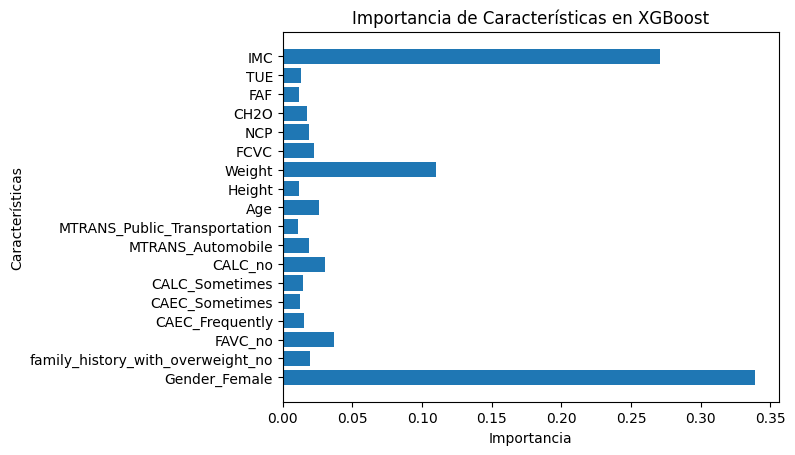

In [64]:
# Visualizar importancia de características con sus nombres
plt.barh(names_column, feature_importances)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de Características en XGBoost')
plt.show()

Busqueda del modelo XGBoost con ajuste de hiperparametros automatico

In [65]:
# Definir la cuadrícula de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'learning_rate': uniform(0.01, 0.5),
    'n_estimators': randint(50, 200),
    'max_depth': randint(2, 5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
}

In [66]:
# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, 
                                   scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [67]:
# Realizar la búsqueda aleatoria en los datos de entrenamiento
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002371D4D0DD0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000237287FA890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023726698990>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000237287DC2D0>},
                   scoring='accuracy', verbose=1)

In [68]:
# Obtenemos lso hiperparametros buscados
best_params = random_search.best_params_

Hacemos uso de la tecnica Hard Voting

In [90]:
# Crear clasificadores individuales
xgb_clf = XGBClassifier(**best_params)
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=10000, multi_class='multinomial')

In [91]:
# Crear el Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('lr', lr_clf)
], voting='hard')

In [92]:
# Entrenar el Voting Classifier
voting_clf.fit(X_train, y_train_encoded)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6249132686423301,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=No...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=197, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=10000,
                                                 multi_class='multinomial',
                                                 random_state=42))])

In [96]:
# Predecir con el conjunto de prueba
y_pred = voting_clf.predict(X_val)

In [94]:
# Validacion cruzada
scores = cross_val_score(voting_clf, X_train, y_train_encoded, cv=10) 
print("Precisión media de la validación cruzada:", "{:.2f}".format(scores.mean()))

Precisión media de la validación cruzada: 0.91


La validacion media es del 90%

In [95]:
# Funcion que da el valor categorico a cada clave del diccionario labels (necesario para volver a tener los valores como texto)
def label_to_text (pred, label_mapping):
    pred_copy = pred

    # Obtener las etiquetas originales en el mismo orden que los valores numéricos
    original_labels = [key for key, value in sorted(label_mapping.items(), key=lambda x: x[1])]

    # Mapear los valores numéricos a las etiquetas originales
    text_predictions = [original_labels[value] for value in pred_copy]
    return text_predictions

Predecir con el conjunto de prueba y el algoritmo mas alto (XGBoost)